# Assignment 1

<b>Group [fill in group number]</b>
* <b> Student 1 </b> : Tommaso Bonomo (1511831)
* <b> Student 2 </b> : Mattia Molon (1511866)

**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.



# Question 1 - Keras implementation (10 pt)

### Word embeddings
Build word embeddings with a Keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training. Use a window size of 2 to train the embeddings (`window_size` in the jupyter notebook). 

1. Build word embeddings of length 50, 150 and 300 using the Skipgram model
2. Build word embeddings of length 50, 150 and 300 using CBOW model
3. Analyze the different word embeddings:
    - Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in the paper. Do not use existing libraries for this task such as Gensim. 
Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. $e_{x}$ denotes the embedding of word $x$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.
    - Give at least 5 different  examples of analogies.
    - Compare the performance on the analogy tasks between the word embeddings and briefly discuss your results.

4. Discuss:
  - Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


<b>HINT</b> See practical 3.1 for some helpful code to start this assignment.


### Import libraries

In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Layer, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

# other helpful libraries
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import pandas as pd

# typing
from typing import List, Union, Tuple, Dict

Using TensorFlow backend.


In [ ]:
print(tf.__version__) #  check what version of TF is imported

2.2.0


### Import file

If you use Google Colab, you need to mount your Google Drive to the notebook when you want to use files that are located in your Google Drive. Paste the authorization code, from the new tab page that opens automatically when running the cell, in the cell below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Navigate to the folder in which `alice.txt` is located. Make sure to start path with '/content/drive/My Drive/' if you want to load the file from your Google Drive.

In [ ]:
# TOMMASO
%cd /content/drive/My Drive/deep learning (Tommaso)/                           

# MATTIA
# %cd drive/My\ Drive/Università/Deep\ Learning/Assignment\ 1

/content/drive/.shortcut-targets-by-id/1Uhw8IQungyqnlJEo9yI6DY9h6yWgz8bk/Assignment 1


In [ ]:
file_name = 'alice.txt'
corpus = open(file_name).readlines()

### Data preprocessing

See Practical 3.1 for an explanation of the preprocessing steps done below.

In [ ]:
# Removes sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # total number of words in the corpus
V = len(tokenizer.word_index) + 1 # total number of unique words in the corpus

In [ ]:
n_samples, V

(27165, 2557)

In [ ]:
# example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('the', 1), ('and', 2), ('to', 3), ('a', 4), ('it', 5)]


In [ ]:
# parameters
window_size = 2
window_size_corpus = 4

## Task 1.1 - Skipgram
Build word embeddings of length 50, 150 and 300 using the Skipgram model.

In [ ]:
#prepare data for skipgram
def generate_data_skipgram(
    corpus: List[List[int]],
    window_size: int,
    seed: int = 4322
) -> Tuple[np.ndarray, np.ndarray]:
    rand_generator = np.random.default_rng(seed=seed)
    
    x: List[int] = []
    y: List[int] = []
    for line in corpus:    
        for idx, word in enumerate(line):
            word_range = rand_generator.integers(1, window_size, endpoint=True)
            
            surrounding_words = line[idx - word_range : idx] + line[idx + 1 : idx + word_range + 1]
            x += [word] * len(surrounding_words)
            y += surrounding_words
        
    
    np_x = np.array(x)
    np_y = np.array(y)
    
    return np_x, np_y

In [ ]:
# create training data
x, y = generate_data_skipgram(corpus, window_size)

In [ ]:
# create skipgram architecture
emb_size = 150
skipgram = Sequential([
    Embedding(V, emb_size, input_length=1),
    Flatten(),
    Dense(V, activation="softmax")
])

skipgram.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

skipgram.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 150)            383550    
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 2557)              386107    
Total params: 769,657
Trainable params: 769,657
Non-trainable params: 0
_________________________________________________________________


<b>HINT</b>: To increase training speed of your model, you can use the free available GPU power in Google Colab. Go to `Edit` --> `Notebook Settings` --> select `GPU` under `hardware accelerator`.

In [ ]:
# train skipgram model
_ = skipgram.fit(x, y, batch_size=32, epochs=3)

Epoch 1/3
2221/2221 [==============================] - 14s 6ms/step - loss: 6.2207 - accuracy: 0.0685
Epoch 2/3
2221/2221 [==============================] - 14s 6ms/step - loss: 5.6296 - accuracy: 0.0951
Epoch 3/3
2221/2221 [==============================] - 14s 6ms/step - loss: 5.4169 - accuracy: 0.1078


In [ ]:
import pickle as pkl
from os.path import join

# save embeddings of the model
def save_embeddings(
    emb_matrix: np.ndarray,
    file_name: str,
    directory: str = './',
    tokenizer: Tokenizer = tokenizer
) -> Dict[str, np.ndarray]:

    emb_dict = {}
    for word, i in tokenizer.word_index.items():
        emb_dict[word] = emb_matrix[i,:]

    file_name += '.pickle'
    path = join(directory, file_name)
    with open(path, 'wb') as file:
        pkl.dump(emb_dict, file, protocol=pkl.HIGHEST_PROTOCOL)

    return emb_dict

# read embeddings
def load_embeddings(
    file_name: str,
    directory: str = './'
) -> Dict[str, np.ndarray]:

    file_name += '.pickle'
    path = join(directory, file_name)
    emb_dict = {} # ci serve questo emb_dict?
    with open(path, 'rb') as file:
        emb_dict = pkl.load(file)

    return emb_dict

In [ ]:
emb_matrix = skipgram.get_weights()[0]
_ = save_embeddings(emb_matrix, f'skp_{emb_size}')

## Task 1.2 - CBOW

Build word embeddings of length 50, 150 and 300 using CBOW model.

In [ ]:
# prepare data for CBOW
def generate_data_cbow(
    corpus: List[List[int]],
    window_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    raw_x = []
    raw_y = []
    for line in corpus:
        for word_idx, word in enumerate(line):
            min_idx = max(0, word_idx - window_size)
            max_idx = min(len(line), word_idx + window_size)
            raw_x.append(
                line[min_idx : word_idx] + line[word_idx + 1 : max_idx + 1]
            )
            raw_y.append(word)
    x = sequence.pad_sequences(raw_x, maxlen=window_size * 2) # Pads all sequences to a fixed length
    y = np.array(raw_y)
    return x, y
    
# create training data
cbow_x, cbow_y = generate_data_cbow(corpus, window_size)

# create CBOW architecture
class AverageLayer(Layer):
    """Custom layer to average out the result of an Embedding layer"""

    def __init__(self):
        super(AverageLayer, self).__init__()
    
    def call(self, inputs):
        return tf.math.reduce_mean(inputs, axis=1)

emb_size = 150
cbow = Sequential([
    Embedding(V, emb_size, mask_zero=True, input_length=window_size_corpus),
    AverageLayer(),
    Dense(V, activation="softmax")
])

cbow.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# train CBOW model
_ = cbow.fit(cbow_x, cbow_y, batch_size=32, epochs=3)

Epoch 1/3
849/849 [==============================] - 6s 7ms/step - loss: 6.4226 - accuracy: 0.0604
Epoch 2/3
849/849 [==============================] - 6s 7ms/step - loss: 5.7655 - accuracy: 0.0774
Epoch 3/3
849/849 [==============================] - 6s 7ms/step - loss: 5.4642 - accuracy: 0.1100


In [ ]:
emb_matrix = cbow.get_weights()[0]
_ = save_embeddings(emb_matrix, f'cbow_{emb_size}')

## Task 1.3 - Analogy function

Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ( $e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for both CBOW and Skipgram model. This means that for each analogy we have 6 outputs. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`) and a boolean answer whether the predicted word **exactly** equals the true word. 

<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted word (sim2) | Embedding | Correct?|
|------|------|------|------|------|
|  queen is to king as woman is to ?	 | man (sim1) | predictd_word(sim2) | SG_50 | True / False|

* Give at least 5 different  examples of analogies.
* Compare the performance on the analogy s between the word embeddings and briefly discuss your results.

In [ ]:
def cosine_similarity(
    v: Union[np.ndarray, tf.Tensor],
    w: Union[np.ndarray, tf.Tensor]
) -> float:
  """v and w should be 1D-vectors, for which to calculate the cosine similarity"""
  
  assert isinstance(v, tf.Tensor) or isinstance(v, np.ndarray), "v must be tf.Tensor or np.ndarray"
  assert isinstance(w, tf.Tensor) or isinstance(w, np.ndarray), "w must be tf.Tensor or np.ndarray"
  
  v = v.numpy() if isinstance(v, tf.Tensor) else v
  w = w.numpy() if isinstance(w, tf.Tensor) else w
  
  if v.ndim > 1:
      v = v.flatten()
  if w.ndim > 1:
      w = w.flatten()

  return v @ w.T / (np.linalg.norm(v) * np.linalg.norm(w))

def score_analogy(
    analogy: List[str],
    answer: str,
    file_names: List[str],
    directory: str = './'
) -> pd.DataFrame:

    question = f"{analogy[0]} is to {analogy[1]} as {analogy[2]} is to ?"               
    dicts = [load_embeddings(f, directory) for f in file_names]                         # dictionaries of embeddings
    preds = [d[analogy[1]] - d[analogy[0]] + d[analogy[2]] for d in dicts]              # computes analogies
    sim_to_answer = [cosine_similarity(p, d[answer]) for p, d in zip(preds, dicts)]     # similarity score between answer and pred
    sim_to_preds: List[float] = []                                                      # similarity score between closest word and pred
    words: List[str] = []                                                               # closest words to preds 

    # find closest words to preds according to cosine similarity
    for p,d in zip(preds, dicts):
        closest_sim = -10
        closest_word = ''
        
        for key in d.keys():
            tmp_sim = cosine_similarity(p, d[key])
            if tmp_sim > closest_sim:
                closest_word = key
                closest_sim = tmp_sim
        sim_to_preds.append(closest_sim)
        words.append(closest_word)

    # are the predictions correct?
    labels = [answer == w for w in words]

    # return pandas dataframe
    grouped_data = {
        'Analogy': [question] * len(file_names),
        'True word (sim1)': [answer] * len(file_names),
        'Predicted Word (sim2)': words,
        'Similarity Score (sim1, emb)': sim_to_answer,
        'Similarity Score (sim2, emb)': sim_to_preds,
        'Embedding': file_names,
        'Correct': labels                  
    }
    return pd.DataFrame.from_dict(grouped_data)      

def score_multiple_analogies(
    analogies: List[List[str]],
    answers: List[str],
    file_names: List[str],
    directory: str = './'
) -> pd.DataFrame: 

    # collect dataframes from score_analogy
    dataframes = []
    for analogy, answer in zip(analogies, answers):
        dataframes.append(score_analogy(analogy, answer, file_names, directory))

    return pd.concat(dataframes)

In [ ]:
V

2557

In [ ]:
analogies = [['queen', 'king', 'woman'], 
             ['speak', 'sing', 'walk'], 
             ['hand', 'arm', 'ear'], 
             ['cauldron', 'cup', 'soup'],
             ['march', 'hare', 'mock']]
answers = ['man', 'dance', 'head', 'tea', 'turtle']
file_names = ['skp_50', 'skp_100', 'skp_150', 'cbow_50', 'cbow_100', 'cbow_150']
# score_multiple_analogies(analogies, answers, file_names)

To ensure the notebook runs without errors and to avoid having to create all embeddings for one execution of the notebook, we provide the table of analogies in markdown format. If needed, please run the relevant cells with the correct embedding size to create, fit and extract embeddings from CBOW or Skipgram.

|    | Analogy                            | True word (sim1)   | Predicted Word (sim2)   |   Similarity Score (sim1, emb) |   Similarity Score (sim2, emb) | Embedding   | Correct   |
|---:|:-----------------------------------|:-------------------|:------------------------|-------------------------------:|-------------------------------:|:------------|:----------|
|  0 | queen is to king as woman is to ?  | man                | five                    |                       0.687184 |                       0.854926 | skp_50      | False     |
|  1 | queen is to king as woman is to ?  | man                | five                    |                       0.420513 |                       0.652613 | skp_100     | False     |
|  2 | queen is to king as woman is to ?  | man                | aloud                   |                       0.391416 |                       0.597433 | skp_150     | False     |
|  3 | queen is to king as woman is to ?  | man                | why                     |                       0.895755 |                       0.944553 | cbow_50     | False     |
|  4 | queen is to king as woman is to ?  | man                | living                  |                       0.745473 |                       0.898306 | cbow_100    | False     |
|  5 | queen is to king as woman is to ?  | man                | youth                   |                       0.637374 |                       0.822879 | cbow_150    | False     |
|  0 | speak is to sing as walk is to ?   | dance              | walk                    |                       0.841845 |                       0.89708  | skp_50      | False     |
|  1 | speak is to sing as walk is to ?   | dance              | walk                    |                       0.642144 |                       0.841242 | skp_100     | False     |
|  2 | speak is to sing as walk is to ?   | dance              | walk                    |                       0.336466 |                       0.784171 | skp_150     | False     |
|  3 | speak is to sing as walk is to ?   | dance              | walk                    |                       0.920021 |                       0.969294 | cbow_50     | False     |
|  4 | speak is to sing as walk is to ?   | dance              | walk                    |                       0.773472 |                       0.926632 | cbow_100    | False     |
|  5 | speak is to sing as walk is to ?   | dance              | walk                    |                       0.728965 |                       0.894645 | cbow_150    | False     |
|  0 | hand is to arm as ear is to ?      | head               | ear                     |                       0.809682 |                       0.914174 | skp_50      | False     |
|  1 | hand is to arm as ear is to ?      | head               | ear                     |                       0.560854 |                       0.781208 | skp_100     | False     |
|  2 | hand is to arm as ear is to ?      | head               | ear                     |                       0.559319 |                       0.806268 | skp_150     | False     |
|  3 | hand is to arm as ear is to ?      | head               | arm                     |                       0.887905 |                       0.931776 | cbow_50     | False     |
|  4 | hand is to arm as ear is to ?      | head               | ear                     |                       0.811051 |                       0.916034 | cbow_100    | False     |
|  5 | hand is to arm as ear is to ?      | head               | ear                     |                       0.613133 |                       0.840454 | cbow_150    | False     |
|  0 | cauldron is to cup as soup is to ? | tea                | soup                    |                       0.510276 |                       0.931435 | skp_50      | False     |
|  1 | cauldron is to cup as soup is to ? | tea                | soup                    |                       0.451926 |                       0.915897 | skp_100     | False     |
|  2 | cauldron is to cup as soup is to ? | tea                | soup                    |                       0.367076 |                       0.913351 | skp_150     | False     |
|  3 | cauldron is to cup as soup is to ? | tea                | soup                    |                       0.867488 |                       0.945122 | cbow_50     | False     |
|  4 | cauldron is to cup as soup is to ? | tea                | soup                    |                       0.701302 |                       0.917336 | cbow_100    | False     |
|  5 | cauldron is to cup as soup is to ? | tea                | soup                    |                       0.502108 |                       0.871263 | cbow_150    | False     |
|  0 | march is to hare as mock is to ?   | turtle             | mock                    |                       0.334164 |                       0.835013 | skp_50      | False     |
|  1 | march is to hare as mock is to ?   | turtle             | mock                    |                       0.341161 |                       0.696909 | skp_100     | False     |
|  2 | march is to hare as mock is to ?   | turtle             | hare                    |                       0.330809 |                       0.690731 | skp_150     | False     |
|  3 | march is to hare as mock is to ?   | turtle             | mock                    |                       0.90023  |                       0.967535 | cbow_50     | False     |
|  4 | march is to hare as mock is to ?   | turtle             | mock                    |                       0.650598 |                       0.90084  | cbow_100    | False     |
|  5 | march is to hare as mock is to ?   | turtle             | mock                    |                       0.528179 |                       0.887851 | cbow_150    | False     |

We implemented the CBOW and Skipgram architectures presented by Mikolov et al [1], following their setting of number of epochs (3) and using Adam as optimizer. We identified 5 analogies: the first 3 are more general we would a good language model to solve, the final 2 are built on particular analogies that make sense in the context of the dataset "Alice in Wonderland". Both models do not perform well in the set of the analogies: they never guess the correct word, and sometimes return one of the words of the analogy as an answer. Sometimes the correct word achieves a relatively high cosine similarity with the embedding of the analogy, but it never is the closest word to that embedding. This is true for all models with different size embeddings (50, 100, 150). Smaller embeddings result in better cosine similarities, although this is to be expected as points are closer between themselves in lower-dimensional spaces.  We believe that the dataset is too small to learn meaningful word embeddings: in their paper, Mikolov et al [1] train implementations of Skipgram and CBOW on a corpus of 6B words, whilst the corpus we use has around 27000 words. This enormous difference in size is probably the main reason behind the poor performance of our models: Skipgram and CBOW simply do not have enough data to form meaningful relationships between words that co-occur frequently. Furthermore, the accuracy of this task is not a meaningful proxy for the quality of the embeddings. As the output layer tries to represent a probability distribution on the vocabulary, computing an accuracy score between this output and a one-hot encoded target does not give a significant insight into the quality of the embeddings.

To improve our similarities scores, we have run different experiments on different models that we explain below:
- Same Skipgram and CBOW models with the addition of a regularization L2 on the final dense layer. We assume that the regularization will penalize the Dense layer producing better encodings in the embedding matrix. The new model achieves higher scores (around 0.95 of cosine similarity) on all the analogies, however, it doesn't mean that the produced embeddings are better compared to the ones produced by the base model. Indeed, the visualization of the embedding space on a 3-dimensional space (using PCA) in Figure 1 (Skipgram and CBOW) shows how all the embeddings are clustered in 2 opposite poles of a sphere. 

- Same base model trained with batch_size = 1. We assume that a smaller batch size will reduce the noise produced by words outside the sequence/pair currently being examined. This new model produces a good 3-dimensional representation of the embeddings, which are evenly distributed in the embedding space as can be seen in Figure 2 (Skipgram and CBOW), however, the cosine similarity score is drastically reduced for all the analogies.

- Same base model trained with a window’s size of 5 rather than 2. We assume that the augmentation of the context space for each word will benefit the embeddings, however, the new model scores are not significantly different from the base model.


In [ ]:
figure1_cbow = pylab.imread("Images/Figure 1 (CBOW).PNG")
figure1_skp = pylab.imread("Images/Figure 1 (SkipGram).PNG")
figure2_cbow = pylab.imread("Images/Figure 2 (CBOW).PNG")
figure2_skp = pylab.imread("Images/Figure 2 (SkipGram).PNG")

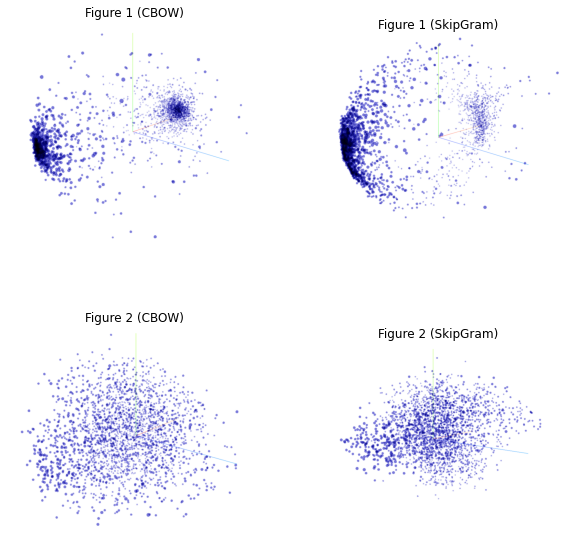

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = pylab.subplots(2, 2, figsize=(10,10))

ax1.imshow(figure1_cbow)
ax1.set_title("Figure 1 (CBOW)")
ax1.set_axis_off()

ax2.imshow(figure1_skp)
ax2.set_title("Figure 1 (SkipGram)")
ax2.set_axis_off()

ax3.imshow(figure2_cbow)
ax3.set_title("Figure 2 (CBOW)")
ax3.set_axis_off()

ax4.imshow(figure2_skp)
ax4.set_title("Figure 2 (SkipGram)")
ax4.set_axis_off()

To view the cited images, you can also visit this [Google Drive folder](https://drive.google.com/open?id=1aZcMmO1OR2fM-wX7YWkP9_1UHq-x2eih).
They were obtained through the [Tensorflow Embedding Projector](https://projector.tensorflow.org/) tool, specifically through PCA decomposition.

## Task 1.4 - Discussion
Answer the following question:
* Given the same number of sentences as input, CBOW and Skipgram arrange the data into different number of training samples. Which one has more and why?


Skipgram has more training samples, as the task it tries to accomplish is different from that of CBOW. Let $(w_{i-R}, ..., w_{i-1}, w_i, w_{i+1}, ..., w_{i+R})$ be a sequence of words with window size $R$. Skipgram is trained on pairs $(w_i, w_j)$, where $w_i$ is the current word evaluated and $w_j$ is a word in a range $[1, C]$ away from $w_i$, with $C$ sampled from a uniform distribution in the range $[1, R]$. Skipgram must correctly identify $w_j$ given $w_i$. In contrast, CBOW is given directly the sequence of words we defined above. CBOW must guess $w_i$ given $(w_{i-R}, ..., w_{i-1}, w_{i+1}, ..., w_{i+R})$ as input.

More specifically, for each word in a corpus of size $W$, we construct 1 sample for CBOW and $O(R)$ samples for Skipgram. Note that the Big-O notation is necessary for Skipgram because of the uniform sampling described above. Therefore, the final dataset for CBOW will have $W$ samples whilst the final dataset for Skipgram will have $O(R \times W)$ samples.

# Question 2 - Peer review (0 pt):
Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member
contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others? You can use the table below to make an overview of how the tasks were divided:



(Mattia) Regarding the code in the notebook, we have first implemented it independently and then discussed the individual solutions together. Regarding the little research we have made, we have first discussed the answers and then divided the parts to write in equal parts between us. Hence, I believe that we have worked equally hard and that we deserve the same grade.

(Tommaso) We worked very well together, discussing the assignment, implementing individual solutions and reviewing our assumptions, and finally experimenting with the models and discussing an appropriate answer to give. Therefore I believe we both deserve the same grade.

| Student name | Task  |
|------|------|
|  student name 1  |  |
| student name 2  | |
| everyone | all tasks|
